# Calibration of Epidemic Models to Data with Epydemix - Part 1

In this tutorial, we will explore how to calibrate epidemic models to data using the ***epydemix*** package.

Let's start importing the necessary libraries:

In [3]:
from scipy import stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from epydemix.model import EpiModel, simulate
from epydemix.visualization import plot_distance_distribution, plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import calibrate, rmse
from epydemix.utils import compute_simulation_dates

import seaborn as sns   
colors = sns.color_palette("Dark2")

## Model Calibration 

***Epydemix*** currently supports 3 calibration methods: 


1. ***ABC-SMC Calibration***: this is the most sophisticated supported method which implements the Approximate Bayesian Computation Sequential Monte Carlo (ABC-SMC) algorithm. In general, this method allows to achieve more accurate results, but may be more computationally expensive. The method implemented in Epydemix is the one described in [Toni et al, 2009](https://pubmed.ncbi.nlm.nih.gov/19205079)

2. ***ABC Rejection***: this method implements the simple Approximate Bayesian Computation Rejection algorithm, for more details see [Minter et al, 2019](https://www.sciencedirect.com/science/article/pii/S175543651930026X)

3. ***Top X% Simulations***: this method implements a variation of the ABC rejection algorithm, where, instead of defining a tolerance and accepting/rejecting based on this, a total budget of simulations is run and the final set of accepted particles is the top X%, regardless of any tolerance threshold. This guarantees results in an allocated amount of time, but it is less accurate and robust than the other two methods. For this reason, we suggest to use this method mostly for exploratory purposes or for recurrent tasks that needs a fixed elapsing time.


First, we import epidemiological data on which we want to calibrate the model. In particular we start considering the dataset ```incidence_data.csv```, where the quantity of interest is the number of newly infected individuals at each time step (i.e., incidence) for some disease in Indonesia. The data has been generated applying noise to the output of a SIR model with known transmission and recovery rate.

Text(0, 0.5, 'New Infections')

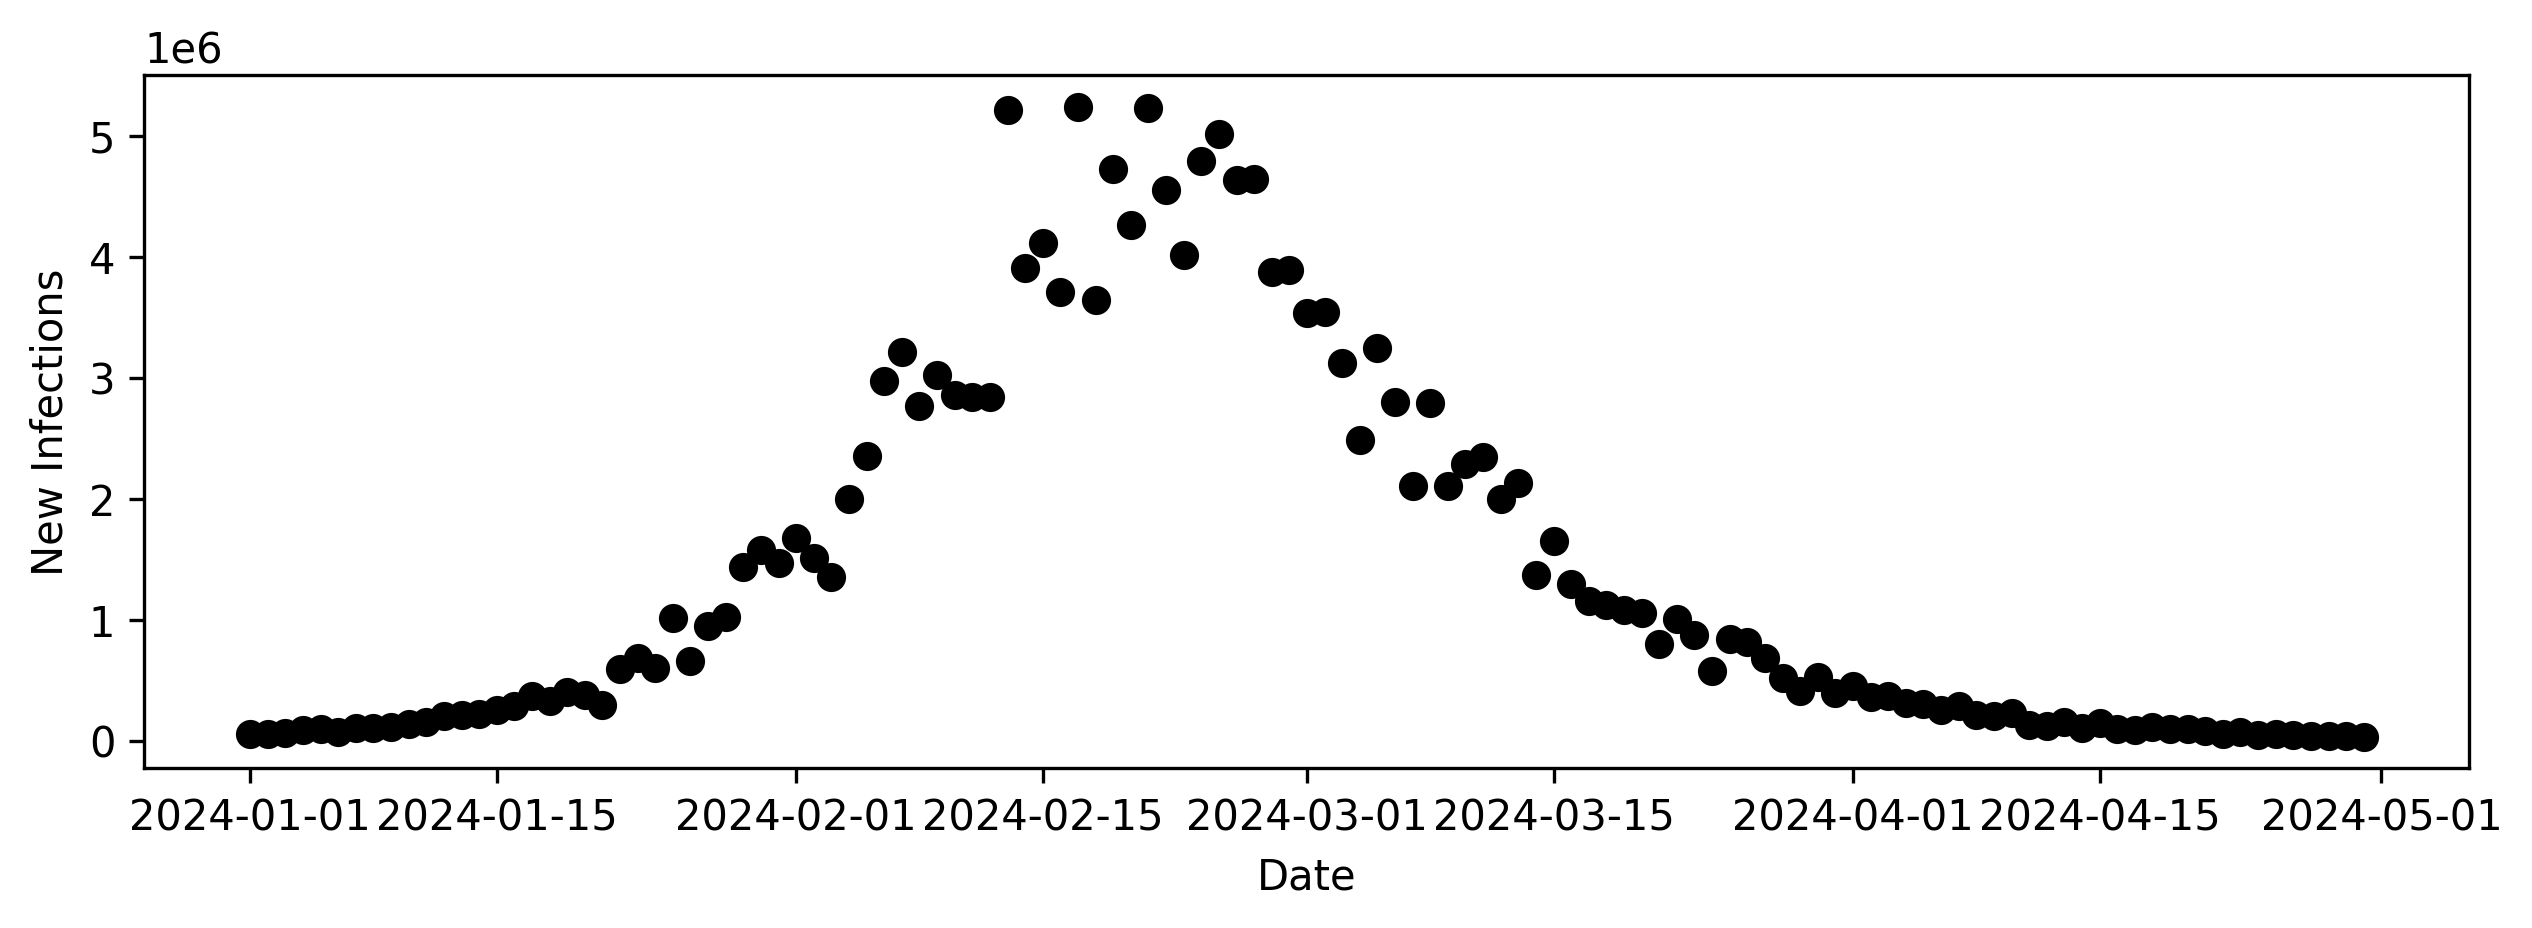

In [4]:
data = pd.read_csv('./data/incidence_data.csv')
data["date"] = pd.to_datetime(data["date"])

fig, ax = plt.subplots(dpi=300, figsize=(10, 3))
plt.plot(data["date"], data["data"], label="I", color="k", linestyle="None", marker="o")
plt.xlabel("Date")
plt.ylabel("New Infections")

Next, we create an SIR model using ***epydemix*** and we set the right population data:

In [5]:
model = EpiModel(predefined_model='SIR')
model.import_epydemix_population(population_name="Indonesia")
print(model)

EpiModel(name='EpiModel')
Compartments: 3
  Susceptible, Infected, Recovered
Transitions: 2
  Transitions between compartments:
    Susceptible -> Infected, rate: transmission_rate
    Infected -> Recovered, rate: recovery_rate
Parameters: 2
  Model parameters:
    transmission_rate: 0.3
    recovery_rate: 0.1
Population: Indonesia
  Population size: 282353643 individuals
  Demographic groups: 5
    0-4, 5-19, 20-49, 50-64, 65+



 Before running the calibration, we need to setup arguments for the simulations, including simulation dates, initial conditions, and model parameters:

In [6]:
# initial conditions (we assume fully S population except for 0.05% infected individual across age groups)
initial_conditions = {"Susceptible": model.population.Nk - (model.population.Nk * 0.05 / 100).astype(int), 
                      "Infected": (model.population.Nk * 0.05/100).astype(int),
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates = compute_simulation_dates(start_date=data.date.values[0], end_date=data.date.values[-1])

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "start_date": data.date.values[0],
              "end_date": data.date.values[-1]
              }

Finally, we need to define the prior distributions for the free parameters of the model. In Epydemix, prior distributions are specified using `scipy.stats` distribution functions. These functions provide a wide range of options for both continuous and discrete parameter distributions. Priors must be defined as a dictionary where:
- Keys are the parameter names.
- Values are the corresponding `scipy.stats` distribution functions.

In thi tutorial, we assume a uniform prior distribution for both the transmission and recovery rate:

In [7]:
priors = {"transmission_rate": stats.uniform(0.010, 0.020), 
          "recovery_rate": stats.uniform(0.15, 0.1)}

We can now run the calibration. We will apply all three methods and then we will compare results. 

The `calibration` function in **Epydemix** is designed with flexibility in mind. It takes as input a simulation function that meets a single key requirement: it must return a dictionary containing a key `'data'`. This key should store the output quantity that will be used to compute errors and perform particle selection during the calibration process.

This minimal requirement allows the `calibration` function to work not only with models built in **Epydemix** but also with external models. As long as the external simulation function adheres to this interface, you can use the same calibration pipeline to fine-tune parameters and evaluate model performance.

In this tutorial, we will use an **Epydemix** model, but to meet the interface requirements of the `calibration` function, we need to define a wrapper function around the Epydemix simulation function. 

### Why Use a Wrapper Function?

This wrapper function specifies which output quantity from the model should be used for model selection during calibration.
Additionally, the wrapper function provides significant flexibility by allowing you to:
1. **Pre-process Inputs**: Adjust or transform the input parameters before passing them to the simulation.
2. **Select Relevant Outputs**: Extract specific quantities from the model's output that are relevant for calibration, such as time series data or summary statistics.
3. **Post-process Outputs**: Compute additional metrics, such as aggregated quantities, or transformed variables, to facilitate comparison with observed data.

In [8]:
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    return {"data": results.transitions["Susceptible_to_Infected_total"]}

Let's start running the ABC-SMC function with 5 generations by 100 accepted particles each and the Root Mean Squared Error as distance function: 

In [9]:
results_abc_smc = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": data["data"].values}, 
                    num_particles=100, 
                    max_generations=5, 
                    distance_function=rmse)

Running generation 1, epsilon: 2079510.0310902707
	Elapsed time: 00:00:09
Running generation 2, epsilon: 1516149.4549602086
	Elapsed time: 00:00:09
Running generation 3, epsilon: 890566.171976039
	Elapsed time: 00:00:08
Running generation 4, epsilon: 555112.843417186
	Elapsed time: 00:00:07
Running generation 5, epsilon: 404039.82780828874
	Elapsed time: 00:00:11


Next we run the ABC rejection algorithm, setting a tolerance based on the that of the ABC-SMC algorithm in the last generations:

In [10]:
results_abc_rejection = calibrate(strategy="abc_rejection", 
                                  simulation_function=simulate_wrapper, 
                                  priors=priors, 
                                  parameters=parameters, 
                                  observed_data={"data": data["data"].values}, 
                                  num_particles=100, 
                                  epsilon=400000,
                                  distance_function=rmse)

Finally, we run the Top X% Simulations strategy, giving a total simulation budget similar to the total simulations run by the ABC-SMC algorithm and taking the top 10%, in order to have 100 simulations accepted:

In [11]:
results_top_perc = calibrate(strategy="abc_top_fraction", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    parameters=parameters, 
                    observed_data={"data": data["data"].values}, 
                    Nsim=1000,
                    top_fraction=0.1,
                    distance_function=rmse)

Finally, we compare the results from the three calibration methods. To do this, we plot the number of infected individuals as reported in the target data alongside the estimates from each of the three calibration algorithms.

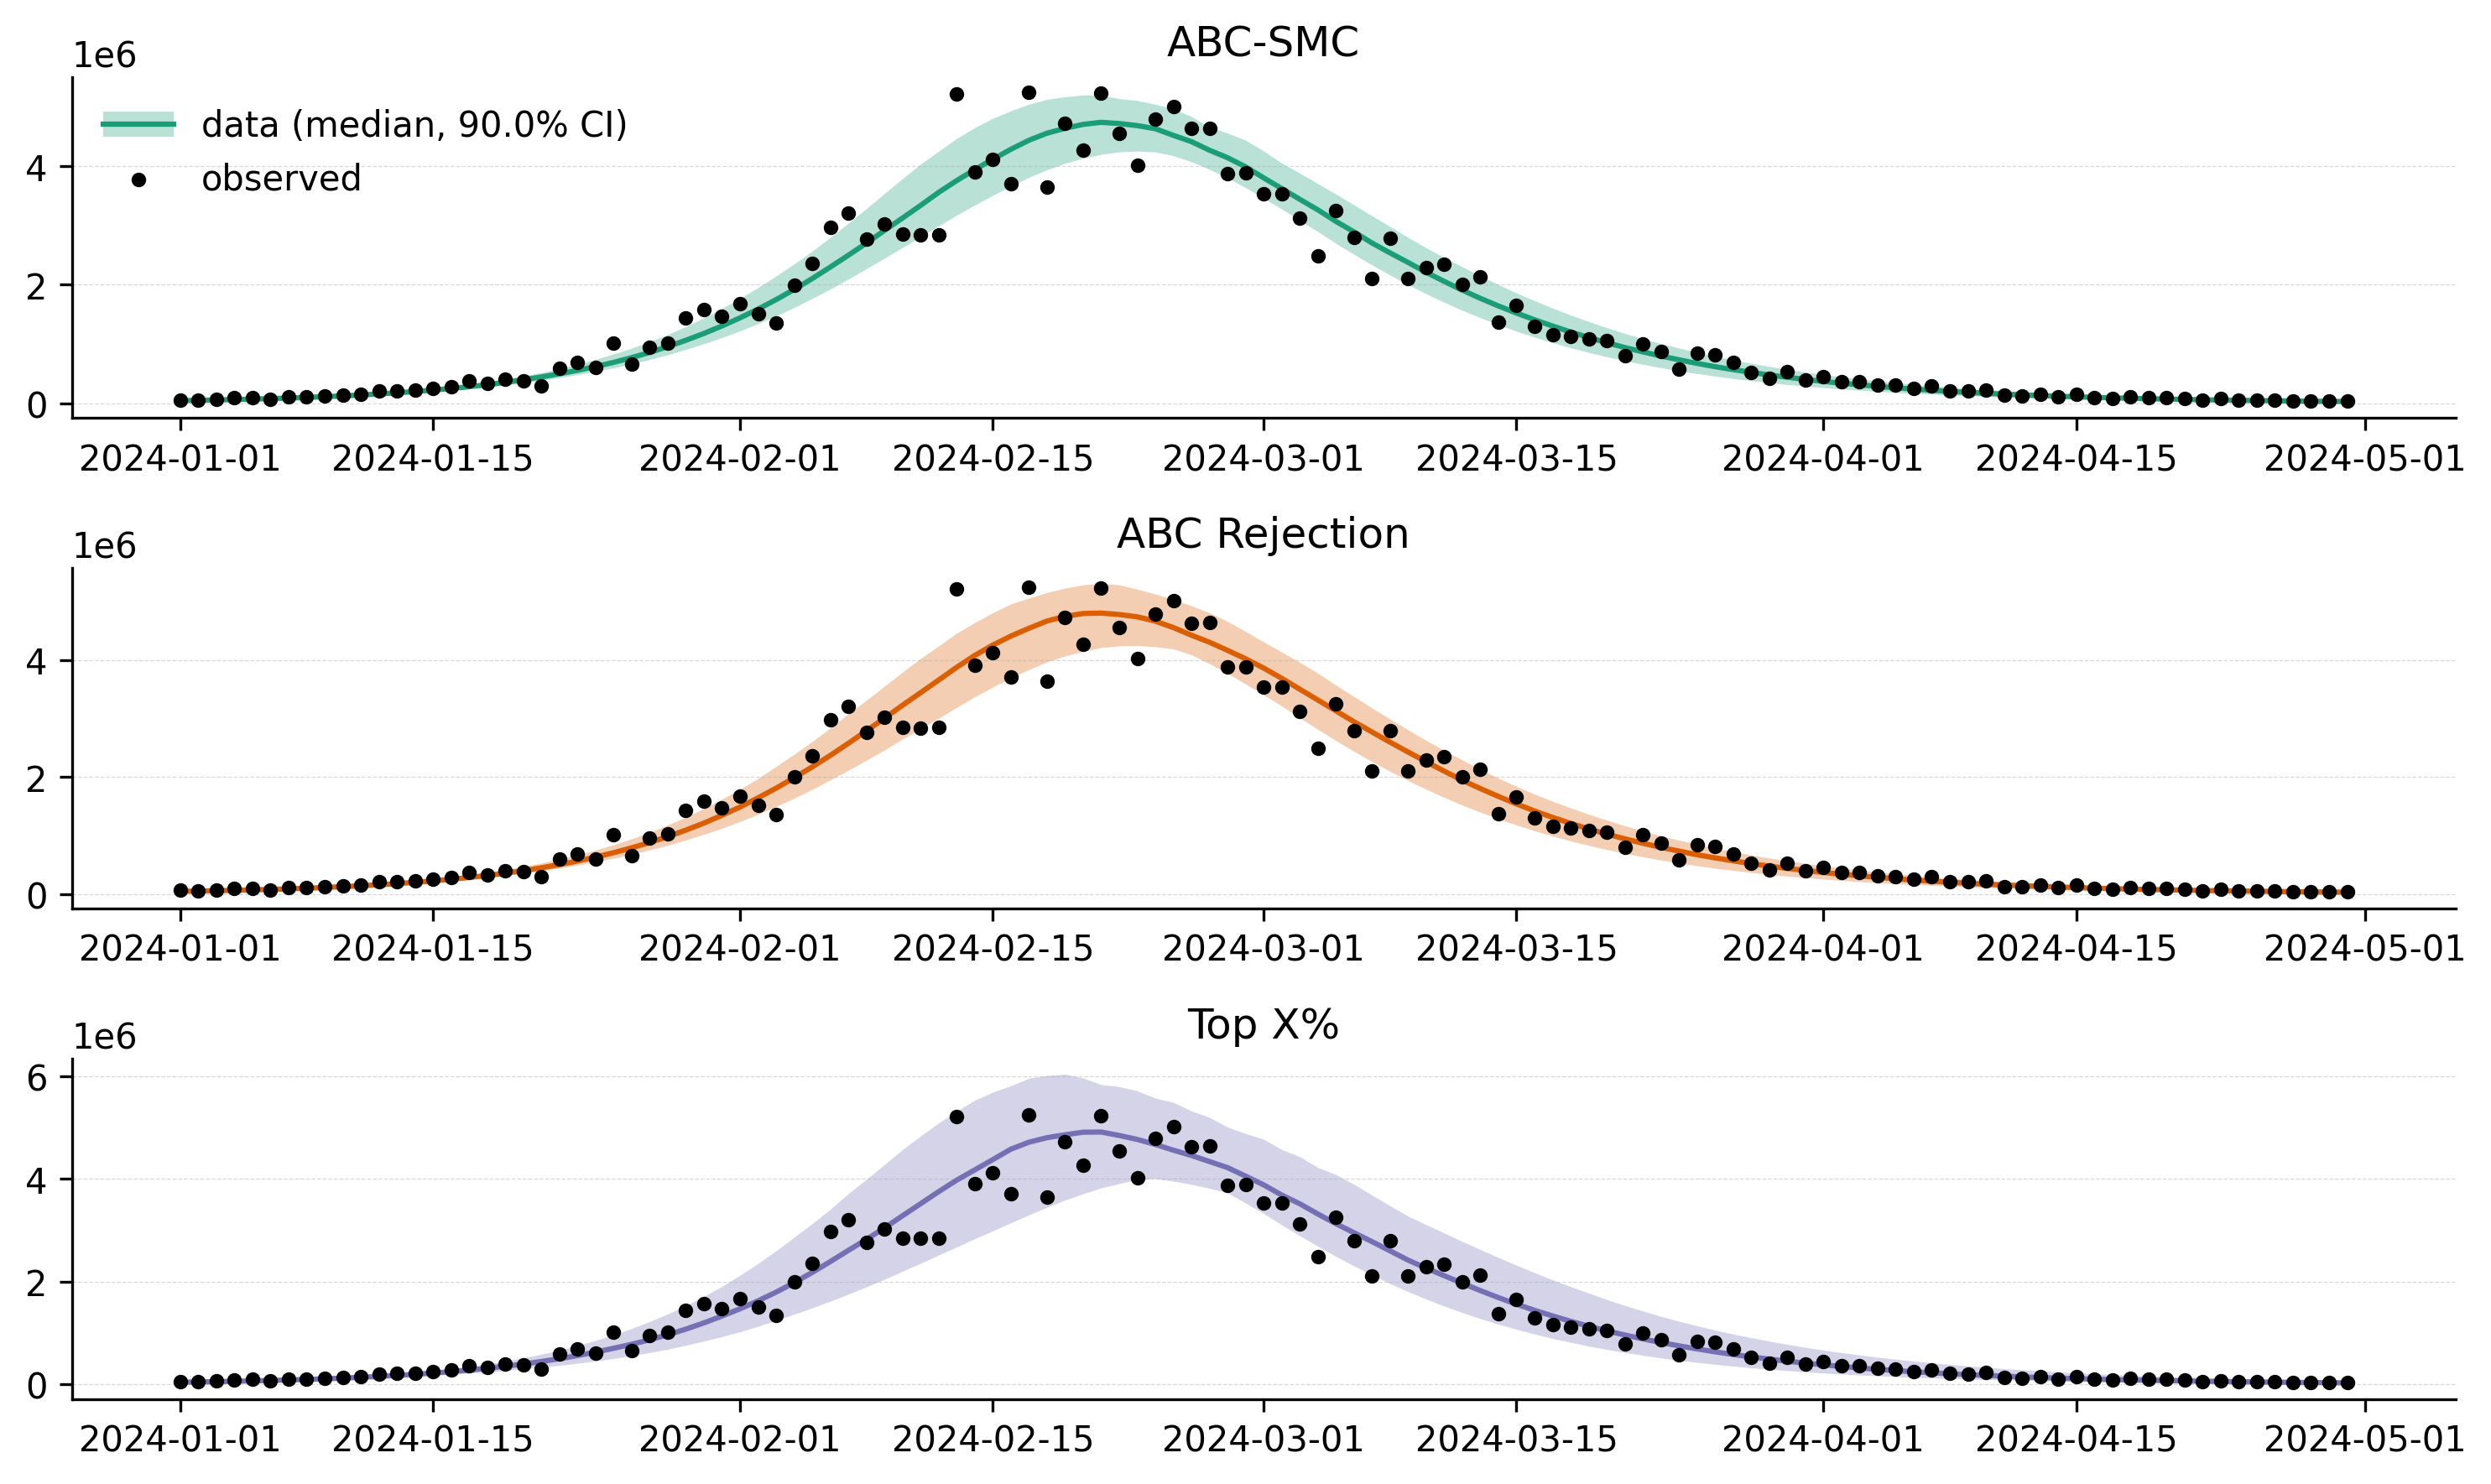

In [16]:
# compute quantiles 
df_quantiles_abc_smc = results_abc_smc.get_calibration_quantiles(dates=simulation_dates)
df_quantiles_abc_rejection = results_abc_rejection.get_calibration_quantiles(dates=simulation_dates)
df_quantiles_top_perc = results_top_perc.get_calibration_quantiles(dates=simulation_dates)

fig, axes = plt.subplots(3, 1, figsize=(10, 6), dpi=300)
plot_quantiles(df_quantiles_abc_smc, columns="data", data=data, ax=axes[0], title="ABC-SMC", colors=colors[0], show_data=True, labels=["New Infections"])   
plot_quantiles(df_quantiles_abc_rejection, columns="data", data=data, ax=axes[1], show_legend=False, title="ABC Rejection", colors=colors[1], show_data=True)
plot_quantiles(df_quantiles_top_perc, columns="data", data=data, ax=axes[2], show_legend=False, title="Top X%", colors=colors[2], show_data=True)
plt.tight_layout()

Additionally, we can visualize the 2D posterior distributions of the free parameters estimated by the three calibration algorithms.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300, sharex=True, sharey=True)  

plot_posterior_distribution_2d(results_abc_smc.get_posterior_distribution(), "transmission_rate", "recovery_rate", ax=axes[0], kind="kde", title="ABC-SMC", prior_range=False)
plot_posterior_distribution_2d(results_abc_rejection.get_posterior_distribution(), "transmission_rate", "recovery_rate", ax=axes[1], kind="kde", title="ABC Rejection", prior_range=False)
plot_posterior_distribution_2d(results_top_perc.get_posterior_distribution(), "transmission_rate", "recovery_rate", ax=axes[2], kind="kde", title="Top X%", prior_range=False)
plt.tight_layout()

Marginal posterior distributions of single parameters can also be visualized.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), dpi=300)

plot_posterior_distribution(results_abc_smc.get_posterior_distribution(), "transmission_rate", ax=axes[0], kind="kde", title="Transmission rate", prior_range=False, color=colors[0], label="ABC-SMC")
plot_posterior_distribution(results_abc_rejection.get_posterior_distribution(), "transmission_rate", ax=axes[0], kind="kde", title="Transmission rate", prior_range=False, color=colors[1], label="ABC Rejection")
plot_posterior_distribution(results_top_perc.get_posterior_distribution(), "transmission_rate", ax=axes[0], kind="kde", title="Transmission rate", prior_range=False, color=colors[2], label="Top X%")
axes[0].legend()    

plot_posterior_distribution(results_abc_smc.get_posterior_distribution(), "recovery_rate", ax=axes[1], kind="kde", title="Recovery rate", prior_range=False, color=colors[0], label="ABC-SMC")
plot_posterior_distribution(results_abc_rejection.get_posterior_distribution(), "recovery_rate", ax=axes[1], kind="kde", title="Recovery rate", prior_range=False, color=colors[1], label="ABC Rejection")
plot_posterior_distribution(results_top_perc.get_posterior_distribution(), "recovery_rate", ax=axes[1], kind="kde", title="Recovery rate", prior_range=False, color=colors[2], label="Top X%")
axes[1].legend()

To assess the performance of the calibration algorithms further, we can analyze the distribution of distances (i.e., RMSE) for the accepted parameters.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
plot_distance_distribution(results_abc_smc.get_distances(), ax=ax, kind="kde", color=colors[0], label="ABC-SMC", xlabel="RMSE")
plot_distance_distribution(results_abc_rejection.get_distances(), ax=ax, kind="kde", color=colors[1], label="ABC Rejection", xlabel="RMSE")
plot_distance_distribution(results_top_perc.get_distances(), ax=ax, kind="kde", color=colors[2], label="Top X%", xlabel="RMSE")
ax.legend()